In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler



In [157]:
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


In [159]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np

Data Loading and Preprocessing:

1.Read Dataset: Load data from data.csv with ISO-8859-1 encoding.

2.Convert Dates: Convert the Order Date column to DateTime format, handling errors (errors='coerce') and ensuring the day-first format.

3.Handle Missing Dates: Drop rows where Order Date is missing.

4.Set Index: Set Order Date as the DataFrame index.

In [85]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')
df.dropna(subset=['Order Date'], inplace=True)
df.set_index('Order Date', inplace=True)


In [87]:
df['Sales_Sqrt'] = df['Sales']

Date-Based Features:

Day of Week: Extract the day of the week as a number (0 for Monday, 6 for Sunday).

Weekend Flag: Create a binary column (1 for weekends, 0 for weekdays).

Month, Quarter, Year: Extract the month, quarter, and year from the index.


In [89]:
df['DayOfWeek']=df.index.dayofweek
df['IsWeekend']=(df['DayOfWeek'] >= 5).astype(int)
df['Month']=df.index.month
df['Quarter']=df.index.quarter
df['Year']=df.index.year

Seasonal Feature:

get_season Function: Map months to their respective seasons:

Winter: December, January, February

Spring: March, April, May

Summer: June, July, August

Fall: September, October, November

In [91]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

In [93]:
df['Season']=df['Month'].apply(get_season)

In [95]:
df['Season']

Order Date
2012-07-31    Summer
2013-02-05    Winter
2013-10-17      Fall
2013-01-28    Winter
2013-11-05      Fall
               ...  
2014-06-19    Summer
2014-06-20    Summer
2013-12-02    Winter
2012-02-18    Winter
2012-05-22    Spring
Name: Season, Length: 51290, dtype: object

1.Encoding Categorical Variables:

Apply one-hot encoding to Category, Ship Mode, and Season, excluding the first category in each case (drop_first=True).

2.Zero-Sales Indicator:

is_zero_sales: Create a binary flag indicating rows where Sales_Sqrt equals zero.

3.Product-Level Statistics

Product Aggregates:

Total Sales: Sum of Sales_Sqrt for each product.

Zero-Sales Rate: Proportion of zero-sales occurrences for each product.

In [97]:
for lag in range(1, 15):
    df['Lag_' + str(lag)] = df['Sales_Sqrt'].shift(lag)

In [99]:
df['Lag_3_MA'] = df['Sales_Sqrt'].shift(3).rolling(window=3).mean()
df['Lag_7_MA'] = df['Sales_Sqrt'].shift(7).rolling(window=7).mean()

In [101]:
df = pd.get_dummies(df, columns=['Category', 'Ship Mode', 'Season'], drop_first=True)

In [103]:
df['is_zero_sales'] = (df['Sales_Sqrt'] == 0).astype(int)
product_stats = df.groupby('Product ID').agg({
    'Sales_Sqrt': 'sum',
    'is_zero_sales': 'mean'
}).reset_index()

In [105]:
product_stats

,Product ID,Sales_Sqrt,is_zero_sales
0,FUR-ADV-10000002,159.120,0.0
1,FUR-ADV-10000108,350.070,0.0
2,FUR-ADV-10000183,974.832,0.0
3,FUR-ADV-10000188,124.950,0.0
4,FUR-ADV-10000190,222.360,0.0
...,...,...,...
10287,TEC-STA-10004181,3121.872,0.0
10288,TEC-STA-10004536,1810.620,0.0
10289,TEC-STA-10004542,897.792,0.0
10290,TEC-STA-10004834,204.687,0.0


Product Segmentation:

1.Sales Rank: Compute the sales rank for each product based on total sales (Sales_Sqrt), sorted in descending order.

2.Group Assignment:

G1: High sales rank (top 33%) and low zero-sales rate (bottom 33%).

G2: Low sales rank (bottom 33%) and high zero-sales rate (top 33%).

G3: Default group for all other products.

3.Merge Groups: Add the group information to the main DataFrame by merging with the Product ID.

In [107]:
product_stats['sales_rank']=product_stats['Sales_Sqrt'].rank(ascending=False)

In [109]:
product_stats['group'] = np.select(
    [(product_stats['sales_rank'] <= product_stats['sales_rank'].quantile(0.33)) & (product_stats['is_zero_sales'] <= product_stats['is_zero_sales'].quantile(0.33)),
     (product_stats['sales_rank'] >= product_stats['sales_rank'].quantile(0.67)) & (product_stats['is_zero_sales'] >= product_stats['is_zero_sales'].quantile(0.67))
    ],
    ['G1', 'G2'], default='G3')
df = df.merge(product_stats[['Product ID', 'group']], on='Product ID', how='left')

Sequence Preparation for Time-Series Modeling

1.Sequence Creation Function:

The create_sequences function generates input (X) and output (y) sequences for time-series forecasting.

Input Sequence: Last n_input days' data.

Output Sequence: Following n_output days' target values.
Data Grouping:

Split the data by product group (G1, G2, G3).

Prepare features for each group based on selected columns.

2.Feature Columns:

Include sales data (Sales_Sqrt) and engineered features like seasonal indicators, lag values, moving averages, and date-based features.

3.Sequence Generation:

For each group, generate sequences using create_sequences.

Store the input and output arrays for further modeling.

Output Shapes:

Log the shapes of X and y for each group to verify sequence creation.

In [111]:
n_input=14 
n_output=7

In [113]:
df.columns

Index(['Row ID', 'Order ID', 'Ship Date', 'Customer ID', 'Customer Name',
       'Segment', 'City', 'State', 'Country', 'Postal Code', 'Market',
       'Region', 'Product ID', 'Sub-Category', 'Product Name', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Shipping Cost', 'Order Priority',
       'Sales_Sqrt', 'DayOfWeek', 'IsWeekend', 'Month', 'Quarter', 'Year',
       'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8',
       'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_3_MA',
       'Lag_7_MA', 'Category_Office Supplies', 'Category_Technology',
       'Ship Mode_Same Day', 'Ship Mode_Second Class',
       'Ship Mode_Standard Class', 'Season_Spring', 'Season_Summer',
       'Season_Winter', 'is_zero_sales', 'group'],
      dtype='object')

In [115]:
for group in df['group'].unique():
    group_data=df[df['group']==group].dropna()
    features = group_data[['Sales_Sqrt', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'DayOfWeek', 
                       'IsWeekend', 'Month', 'Quarter', 'Year', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 
                       'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 
                       'Lag_13', 'Lag_14', 'Lag_3_MA', 'Lag_7_MA']].values



In [117]:
def create_sequences(data, target_column_index, n_input, n_output):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_input
        out_end_ix = end_ix + n_output
        if out_end_ix > len(data):
            break
        
        seq_x = data[i:end_ix]  
        seq_y = data[end_ix:out_end_ix, target_column_index]  
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


Data Preparation :

1.Features and Targets:

Extract features_columns for the model.

Use Sales_Sqrt as the target variable.

2.Grouped Data:

Store the feature and target arrays for each group in a dictionary (data_groups).

In [119]:
data_groups = {}  
for group in df['group'].unique():
    group_data=df[df['group']==group].dropna()  
    features=group_data[['Sales_Sqrt', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'DayOfWeek', 
                       'IsWeekend', 'Month', 'Quarter', 'Year', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 
                       'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 
                       'Lag_13', 'Lag_14', 'Lag_3_MA', 'Lag_7_MA']].values
    target_column_index = 0 
    X, y=create_sequences(features, target_column_index, n_input, n_output)
    print(f"Group: {group}, X shape: {X.shape}, y shape: {y.shape}")  
    data_groups[group] = (X.reshape((X.shape[0], X.shape[1], features.shape[1])), y)


Group: G1, X shape: (3506, 14, 25), y shape: (3506, 7)
Group: G3, X shape: (2692, 14, 25), y shape: (2692, 7)
Group: G2, X shape: (3732, 14, 25), y shape: (3732, 7)


In [121]:

group_metrics = {}
data_groups = {}
n_input = 10 
n_output = 7  
features_columns = [
    'Sales_Sqrt', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'DayOfWeek', 
                       'IsWeekend', 'Month', 'Quarter', 'Year', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 
                       'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 
                       'Lag_13', 'Lag_14', 'Lag_3_MA', 'Lag_7_MA'
]

In [123]:
for group in df['group'].unique():
    group_data = df[df['group'] == group].dropna()
    features = group_data[features_columns].values
    target = group_data['Sales_Sqrt'].values  
    data_groups[group] = (features, target)

Model Training and Evaluation Overview:

1.Voting Regressor: Combines predictions from XGBoost, Random Forest, and Linear Regression models.

2.Evaluation Metrics:

MAE: Average error magnitude.

RMSE: Penalizes large errors.

R²: Variance explained by the model.

MAPE: Error as a percentage of actual values.

Accuracy: Complements MAPE.

3.Workflow:

Split data (80% train, 20% test).

Impute missing values and scale features.

Train and evaluate the model on clean and noisy datasets.

Visualize Actual vs. Predicted sales.

4.Noise Simulation:

Add random noise to test model robustness.

Compare clean vs. noisy data metrics.

5.Outputs:

Metrics and plots for clean and noisy datasets for each group.

In [125]:
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
lr_model = LinearRegression()

In [127]:
voting_model = VotingRegressor(estimators=[('xgb', xgb_model), ('rf', rf_model), ('lr', lr_model)])

In [129]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy = 100 - mape
    return mae, rmse, r2, mape, accuracy

In [131]:
def plot_actual_vs_predicted(y_true, y_pred, group):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label="Actual", marker='o', color='b', linestyle='-')
    plt.plot(y_pred, label="Predicted", marker='x', color='r', linestyle='--')
    plt.title(f'Actual vs Predicted Sales for Group {group} (Voting Regressor)')
    plt.xlabel('Index')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid()
    plt.show()


Metrics for Group G1:
MAE: 15.029936932820997
RMSE: 215.48879447268652
R-squared: 0.9581834955363999
MAPE: 0.5963836521713591%
Accuracy: 99.40361634782865%


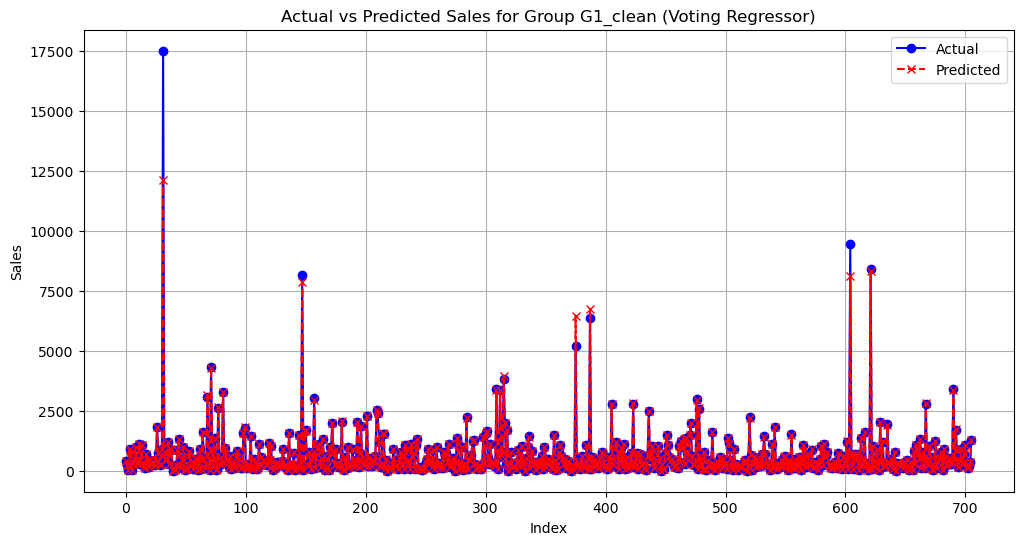


Metrics for Group G1 with Noisy Data:
MAE: 17.291434310160287
RMSE: 227.92278646673435
R-squared: 0.9532185331994368
MAPE: 0.6936822001931359%
Accuracy: 99.30631779980686%


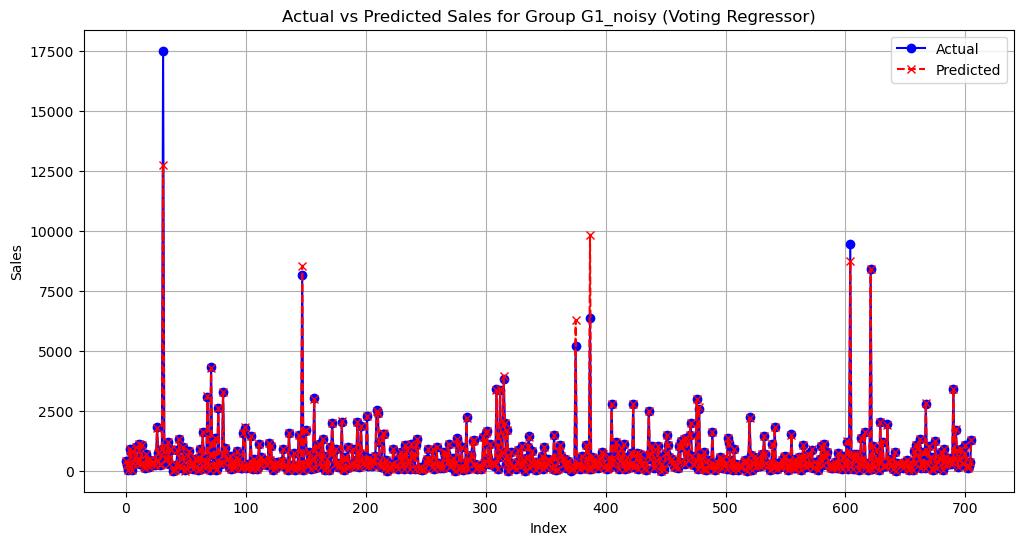

Actual Values for the Last 5 Days:  [ 179.94    99.592  196.784  359.97  1299.99 ]
Predicted Values (Clean) for the Last 5 Days:  [ 180.98806087   99.80927451  198.23864983  358.33994931 1285.69969043]
Predicted Values (Noisy) for the Last 5 Days:  [ 181.27768582   99.34058924  199.52723336  359.64816847 1290.83039259]


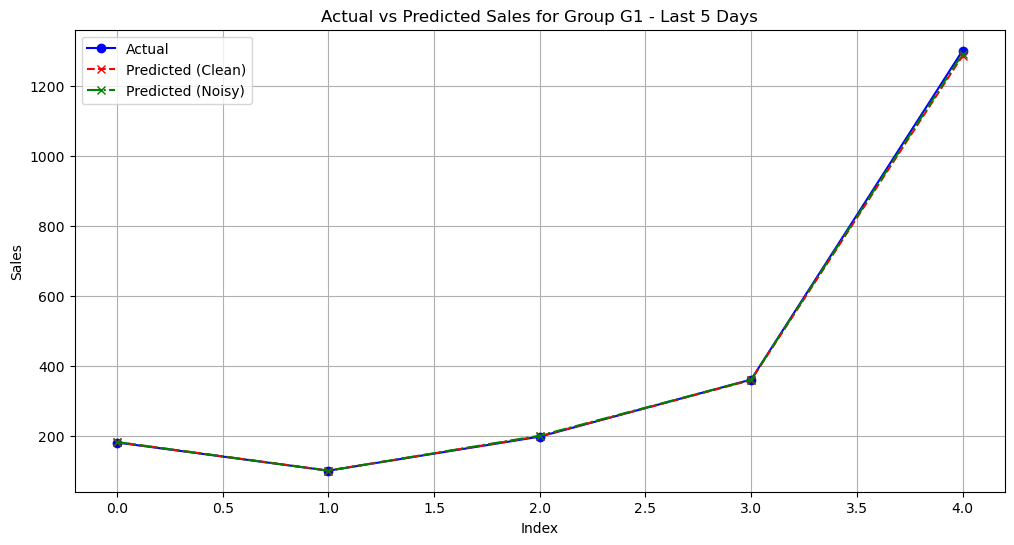


Metrics for Group G3:
MAE: 0.4202886244703194
RMSE: 2.358565238879341
R-squared: 0.9991329882218289
MAPE: 0.6827392590672339%
Accuracy: 99.31726074093277%


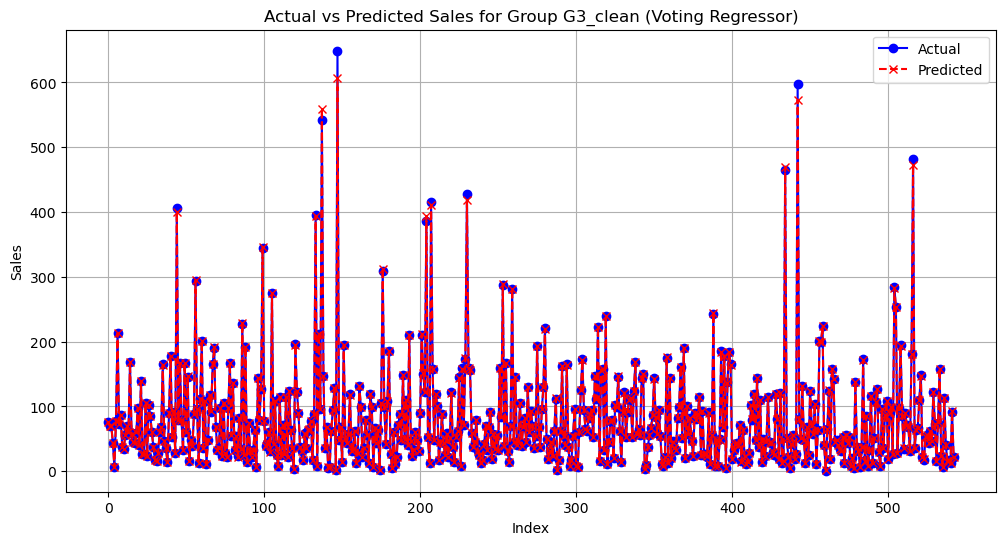


Metrics for Group G3 with Noisy Data:
MAE: 0.4484948774985945
RMSE: 2.29691488401194
R-squared: 0.9991777213498474
MAPE: 0.8704104457533498%
Accuracy: 99.12958955424665%


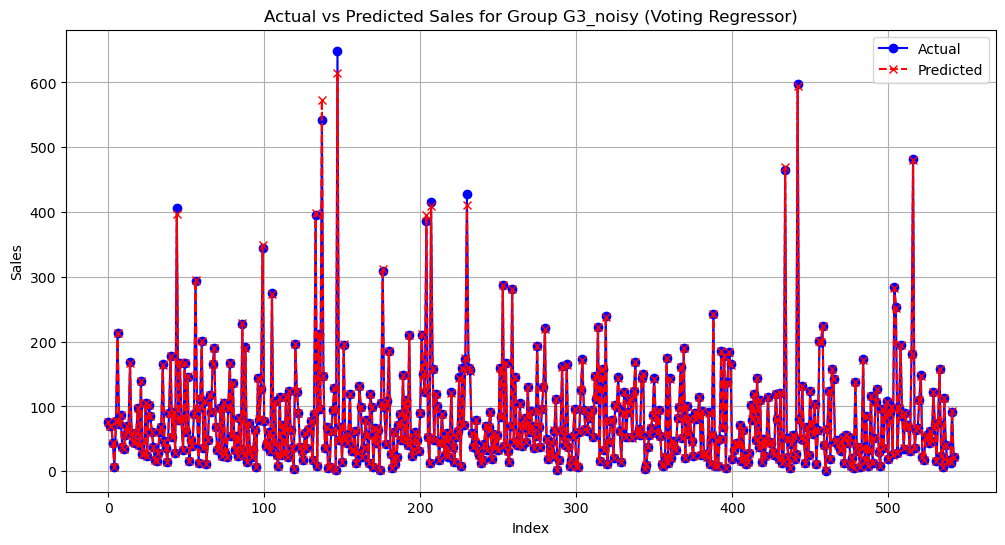

Actual Values for the Last 5 Days:  [15.88  18.176 13.428 91.92  21.48 ]
Predicted Values (Clean) for the Last 5 Days:  [16.00520423 18.05240021 13.34878227 92.29155602 21.49403905]
Predicted Values (Noisy) for the Last 5 Days:  [16.00631364 18.14908555 13.6463022  92.45206557 21.4888879 ]


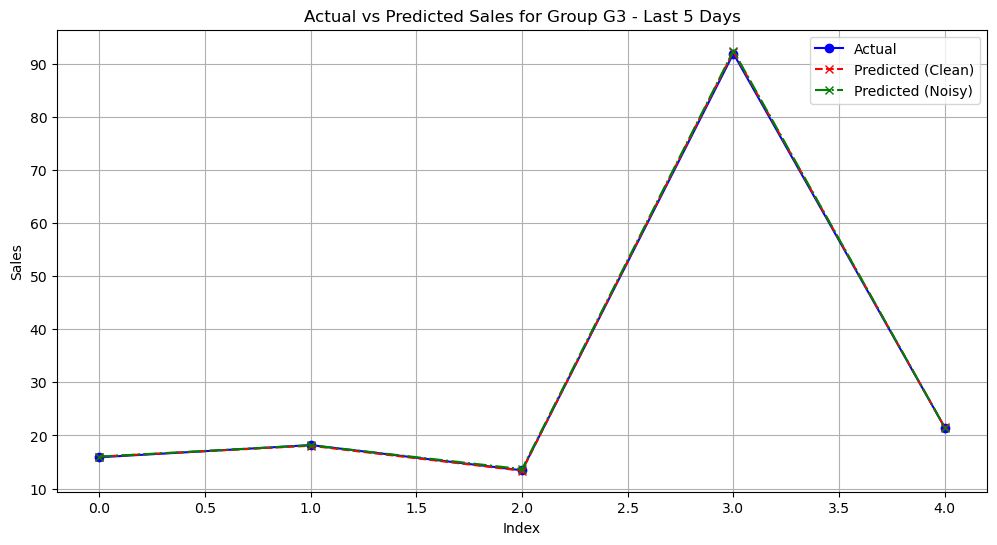


Metrics for Group G2:
MAE: 0.11781015033574166
RMSE: 1.0451387749549186
R-squared: 0.9974585252681054
MAPE: 0.36774036482984934%
Accuracy: 99.63225963517016%


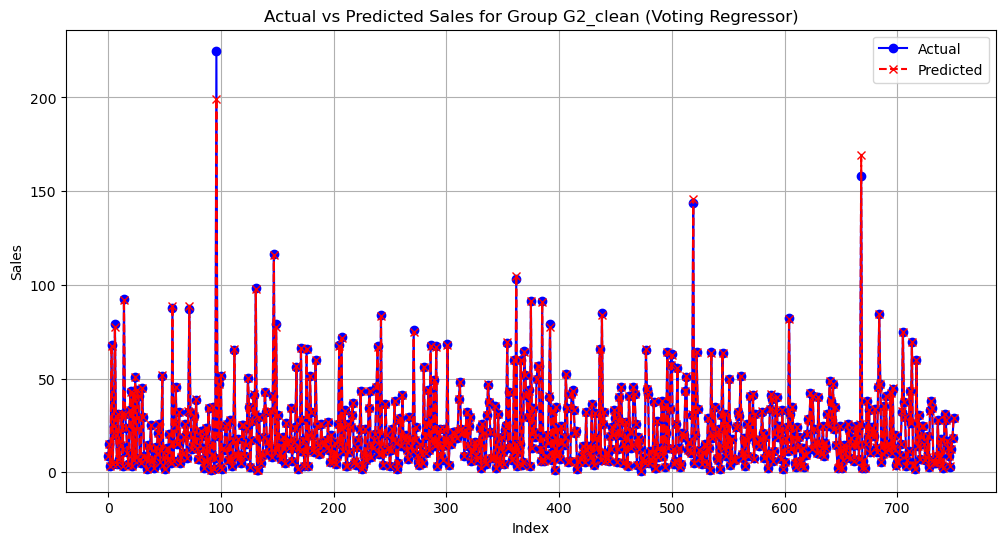


Metrics for Group G2 with Noisy Data:
MAE: 0.18203178568048714
RMSE: 1.178394466081229
R-squared: 0.9967691316358062
MAPE: 0.9621251984315058%
Accuracy: 99.03787480156849%


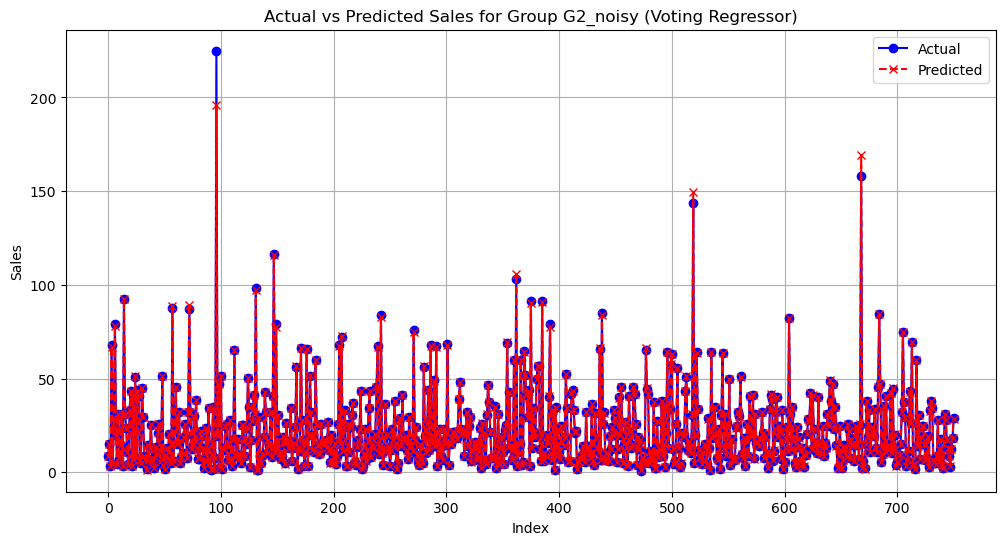

Actual Values for the Last 5 Days:  [ 8.896  3.104 12.645 18.464 28.752]
Predicted Values (Clean) for the Last 5 Days:  [ 8.89761736  3.17188134 12.63066008 18.4400232  28.85529395]
Predicted Values (Noisy) for the Last 5 Days:  [ 8.70157847  3.16854499 12.63443906 18.46543189 28.51122048]


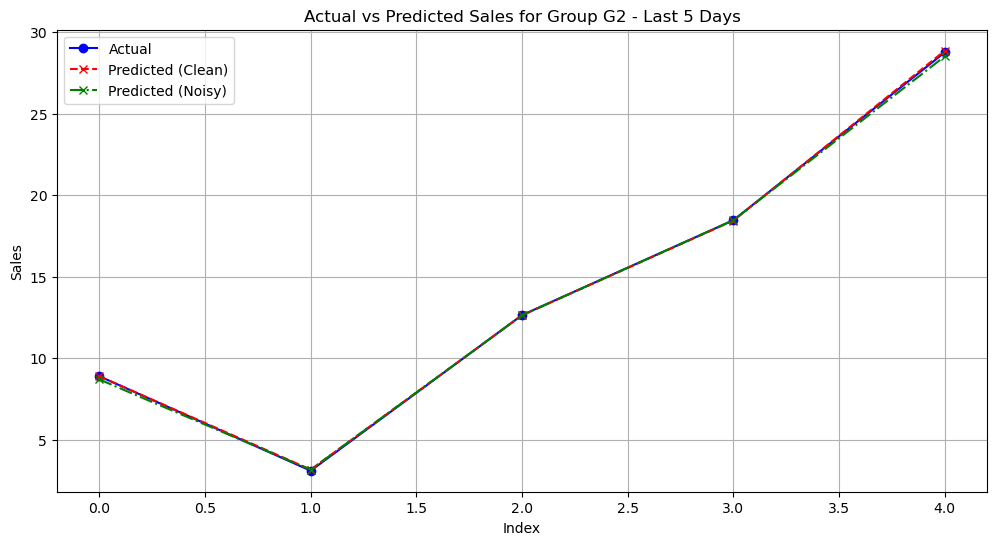

In [133]:
for group, (X, y) in data_groups.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()

    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    voting_model.fit(X_train_scaled, y_train)
    y_pred_clean = voting_model.predict(X_test_scaled)

    mae, rmse, r2, mape, accuracy = evaluate_model(y_test, y_pred_clean)

    print(f"\nMetrics for Group {group}:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R-squared: {r2}")
    print(f"MAPE: {mape}%")
    print(f"Accuracy: {accuracy}%")

    plot_actual_vs_predicted(y_test, y_pred_clean, f'{group}_clean')

    noise_factor = 0.1 
    X_train_noisy = X_train + noise_factor * np.random.randn(*X_train.shape)
    X_test_noisy = X_test + noise_factor * np.random.randn(*X_test.shape)

    X_train_noisy_imputed = imputer.fit_transform(X_train_noisy)
    X_test_noisy_imputed = imputer.transform(X_test_noisy)
    
    X_train_noisy_scaled = scaler.fit_transform(X_train_noisy_imputed)
    X_test_noisy_scaled = scaler.transform(X_test_noisy_imputed)

    voting_model.fit(X_train_noisy_scaled, y_train)
    y_pred_noisy = voting_model.predict(X_test_noisy_scaled)

    mae_noisy, rmse_noisy, r2_noisy, mape_noisy, accuracy_noisy = evaluate_model(y_test, y_pred_noisy)

    print(f"\nMetrics for Group {group} with Noisy Data:")
    print(f"MAE: {mae_noisy}")
    print(f"RMSE: {rmse_noisy}")
    print(f"R-squared: {r2_noisy}")
    print(f"MAPE: {mape_noisy}%")
    print(f"Accuracy: {accuracy_noisy}%")

    plot_actual_vs_predicted(y_test, y_pred_noisy, f'{group}_noisy')

    last_5_actual = y_test[-5:]
    last_5_predicted_clean = y_pred_clean[-5:]
    last_5_predicted_noisy = y_pred_noisy[-5:]

    print("Actual Values for the Last 5 Days: ", last_5_actual)
    print("Predicted Values (Clean) for the Last 5 Days: ", last_5_predicted_clean)
    print("Predicted Values (Noisy) for the Last 5 Days: ", last_5_predicted_noisy)

    plt.figure(figsize=(12, 6))
    plt.plot(last_5_actual, label="Actual", marker='o', color='b', linestyle='-')
    plt.plot(last_5_predicted_clean, label="Predicted (Clean)", marker='x', color='r', linestyle='--')
    plt.plot(last_5_predicted_noisy, label="Predicted (Noisy)", marker='x', color='g', linestyle='-.')
    plt.title(f'Actual vs Predicted Sales for Group {group} - Last 5 Days')
    plt.xlabel('Index')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid()
    plt.show()



Metrics for Group G1:
MAE: 15.029936932820997
RMSE: 215.48879447268652
R-squared: 0.9581834955363999
MAPE: 0.5963836521713591%
Accuracy: 99.40361634782865%


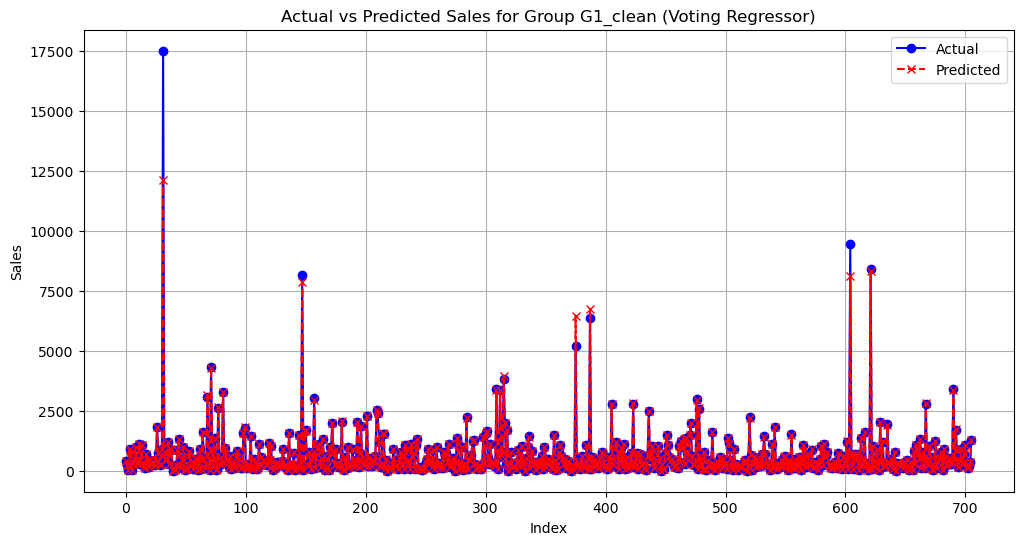


Metrics for Group G1 with Noisy Data:
MAE: 13.324015039462392
RMSE: 216.26380378170123
R-squared: 0.957882167027792
MAPE: 0.6553443521842871%
Accuracy: 99.34465564781571%


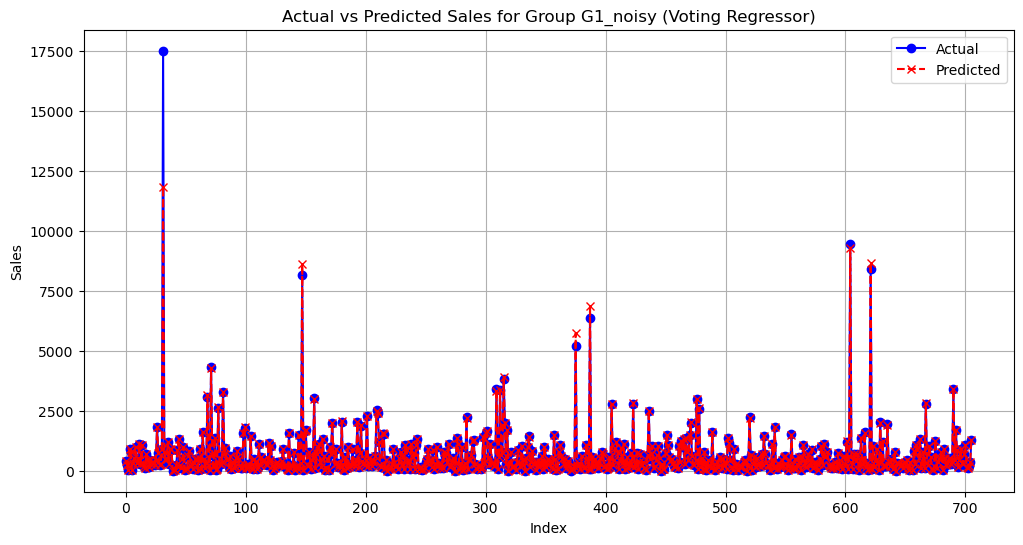


Metrics for Group G3:
MAE: 0.4202886244703194
RMSE: 2.358565238879341
R-squared: 0.9991329882218289
MAPE: 0.6827392590672339%
Accuracy: 99.31726074093277%


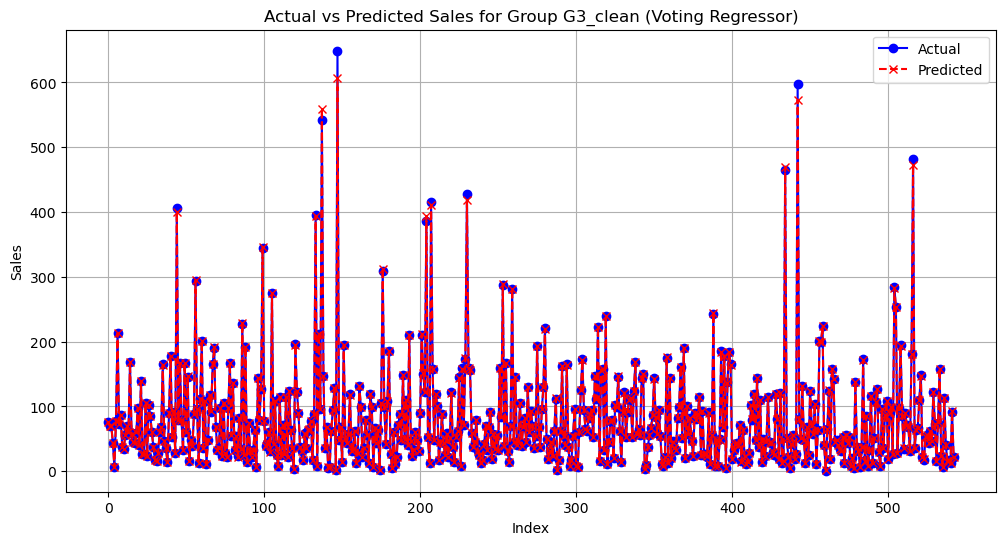


Metrics for Group G3 with Noisy Data:
MAE: 0.48524038106564
RMSE: 2.6003731060263604
R-squared: 0.998946097240093
MAPE: 0.8311219844823142%
Accuracy: 99.16887801551769%


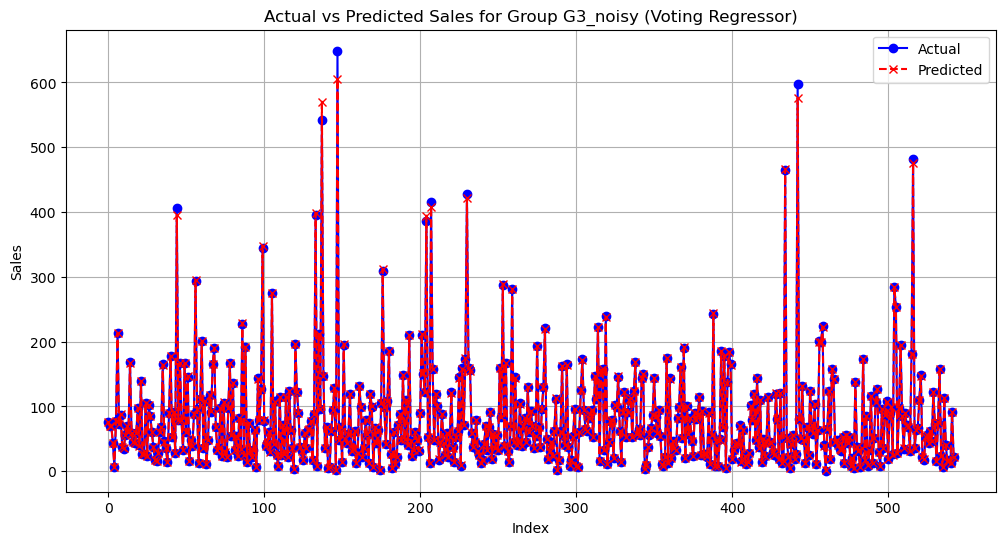


Metrics for Group G2:
MAE: 0.11781015033574166
RMSE: 1.0451387749549186
R-squared: 0.9974585252681054
MAPE: 0.36774036482984934%
Accuracy: 99.63225963517016%


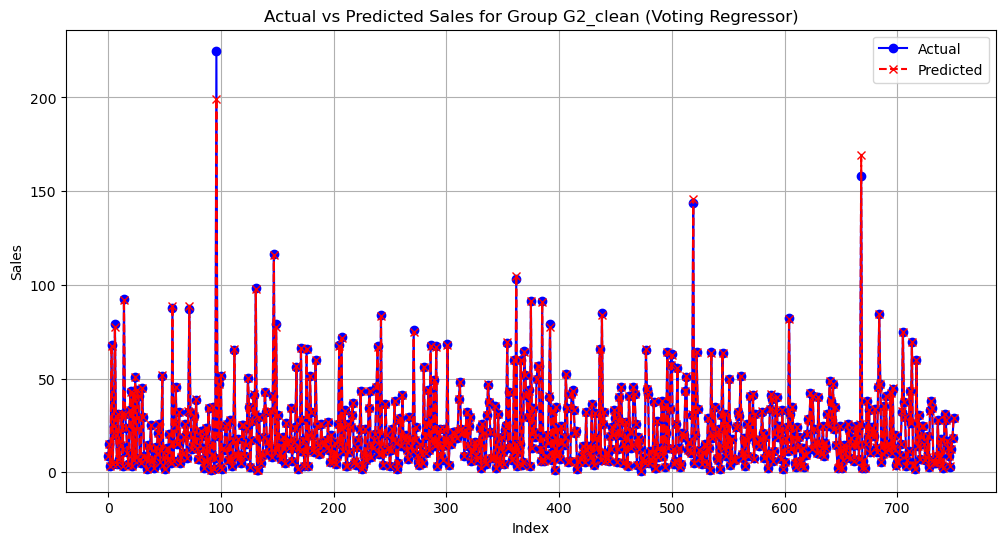


Metrics for Group G2 with Noisy Data:
MAE: 0.1777417929195277
RMSE: 0.9140405484504814
R-squared: 0.99805612291746
MAPE: 0.9929480693817547%
Accuracy: 99.00705193061825%


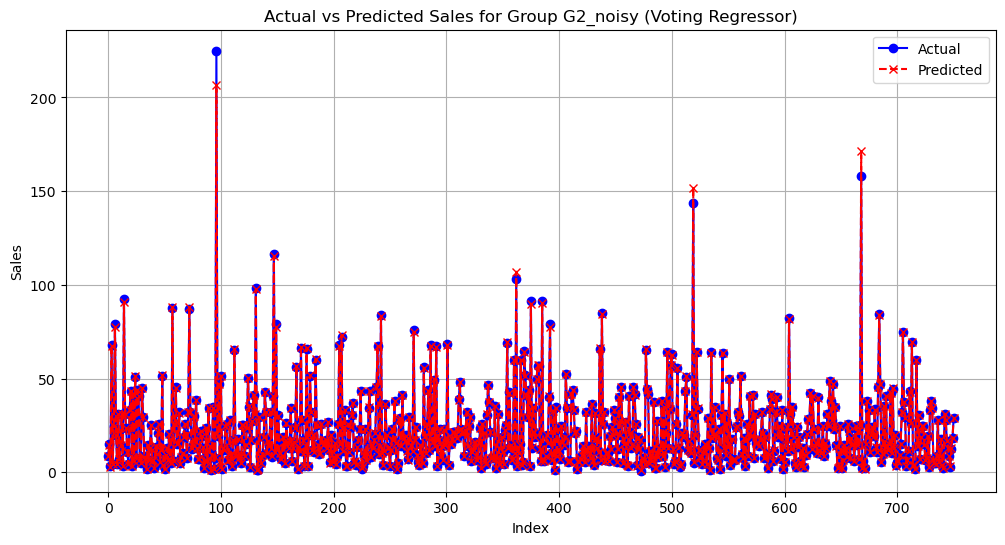

In [62]:
for group, (X, y) in data_groups.items():
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()

    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    
    voting_model.fit(X_train_scaled, y_train)

    y_pred_clean = voting_model.predict(X_test_scaled)

   
    mae, rmse, r2, mape, accuracy = evaluate_model(y_test, y_pred_clean)

    print(f"\nMetrics for Group {group}:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R-squared: {r2}")
    print(f"MAPE: {mape}%")
    print(f"Accuracy: {accuracy}%")

    
    plot_actual_vs_predicted(y_test, y_pred_clean, f'{group}_clean')

    
    noise_factor = 0.1 
    X_train_noisy = X_train + noise_factor * np.random.randn(*X_train.shape)
    X_test_noisy = X_test + noise_factor * np.random.randn(*X_test.shape)

    
    X_train_noisy_imputed = imputer.fit_transform(X_train_noisy)
    X_test_noisy_imputed = imputer.transform(X_test_noisy)
    
    X_train_noisy_scaled = scaler.fit_transform(X_train_noisy_imputed)
    X_test_noisy_scaled = scaler.transform(X_test_noisy_imputed)

    
    voting_model.fit(X_train_noisy_scaled, y_train)

    
    y_pred_noisy = voting_model.predict(X_test_noisy_scaled)


    mae_noisy, rmse_noisy, r2_noisy, mape_noisy, accuracy_noisy = evaluate_model(y_test, y_pred_noisy)

    print(f"\nMetrics for Group {group} with Noisy Data:")
    print(f"MAE: {mae_noisy}")
    print(f"RMSE: {rmse_noisy}")
    print(f"R-squared: {r2_noisy}")
    print(f"MAPE: {mape_noisy}%")
    print(f"Accuracy: {accuracy_noisy}%")

    
    plot_actual_vs_predicted(y_test, y_pred_noisy, f'{group}_noisy')


In [ ]:
HYPERPARAMETER TUNING AND 

In [135]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model1 = LinearRegression()
model2 = DecisionTreeRegressor()
model3 = RandomForestRegressor()


voting_model = VotingRegressor(estimators=[
    ('lr', model1),
    ('dt', model2),
    ('rf', model3)
])


param_grid = {
    'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1]],  
    'rf__n_estimators': [50, 100],                
    'rf__max_depth': [10, 20],                    
    'dt__max_depth': [5, 10]                      
}


grid_search = GridSearchCV(estimator=voting_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae}")
print(f"Test RMSE: {rmse}")
print(f"Test R-squared: {r2}")


Best Parameters: {'dt__max_depth': 10, 'rf__max_depth': 10, 'rf__n_estimators': 50, 'weights': [2, 1, 1]}
Best Score: 0.059647785019579236
Test MAE: 0.06514737453478289
Test RMSE: 0.7416334701572779
Test R-squared: 0.998720275401098


C:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Metrics for Group G1 (Clean Data):
MAE: 6.9941
RMSE: 125.9666
R-squared: 0.9857
MAPE: 0.22%
Accuracy: 99.78%


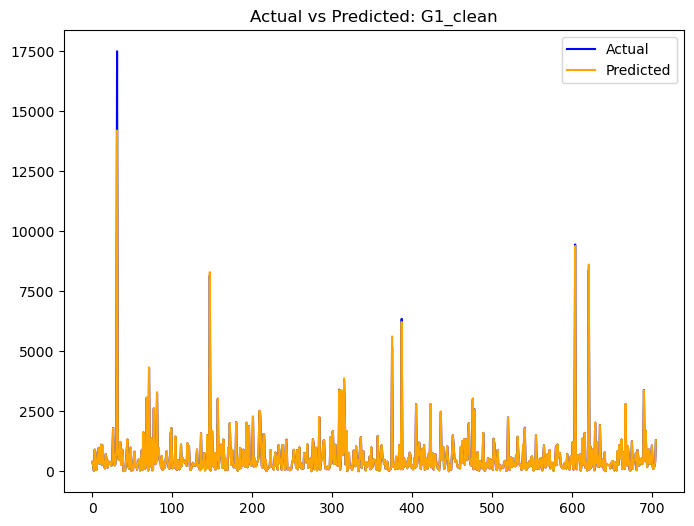


Metrics for Group G1 (Noisy Data):
MAE: 9.0186
RMSE: 131.5121
R-squared: 0.9844
MAPE: 0.27%
Accuracy: 99.73%


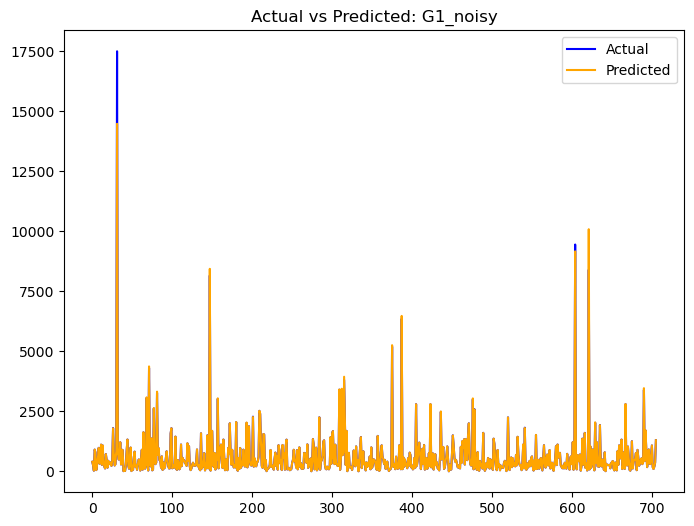

Cross-validated MAE for Group G1: 6.8477

Metrics for Group G3 (Clean Data):
MAE: 0.1743
RMSE: 1.0380
R-squared: 0.9998
MAPE: 0.28%
Accuracy: 99.72%


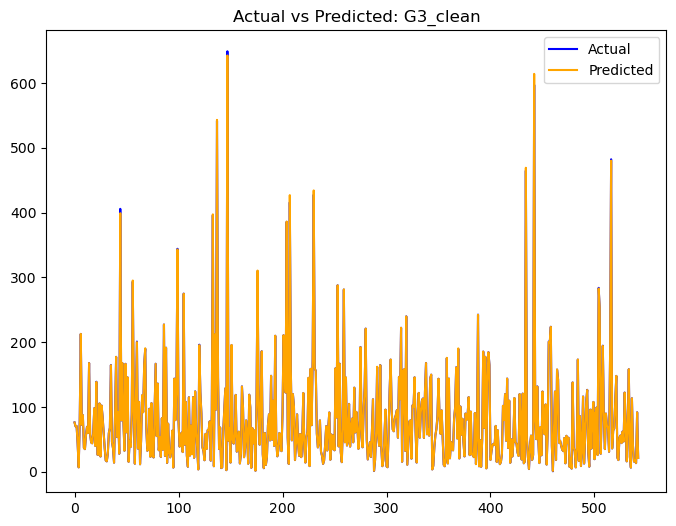


Metrics for Group G3 (Noisy Data):
MAE: 0.1930
RMSE: 0.7937
R-squared: 0.9999
MAPE: 0.51%
Accuracy: 99.49%


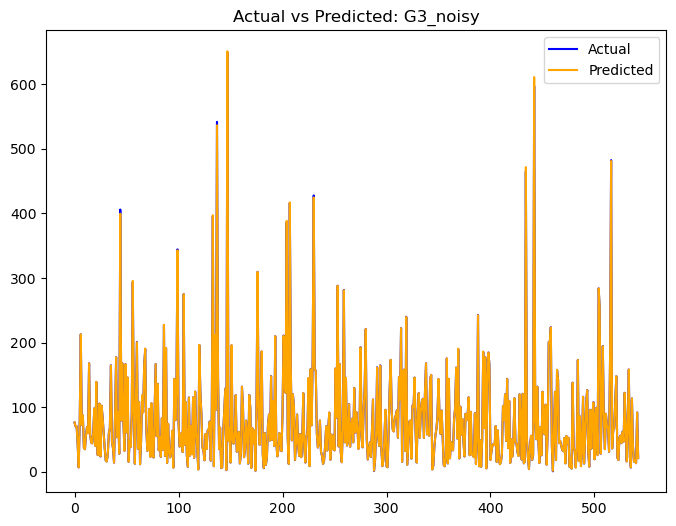

Cross-validated MAE for Group G3: 0.2018

Metrics for Group G2 (Clean Data):
MAE: 0.0701
RMSE: 0.8441
R-squared: 0.9983
MAPE: 0.13%
Accuracy: 99.87%


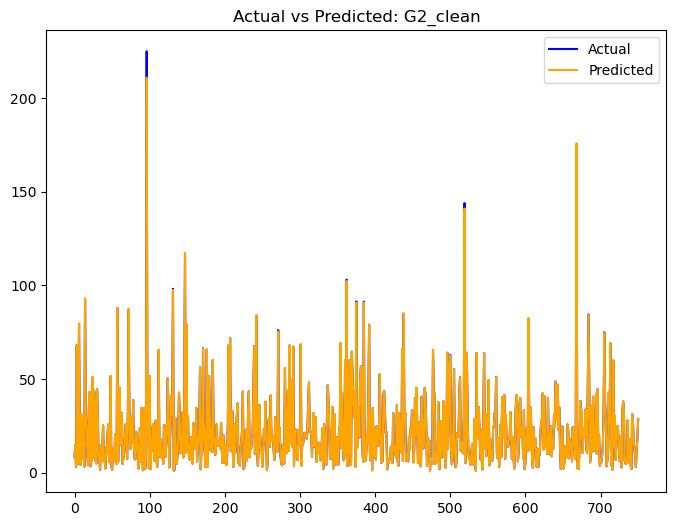


Metrics for Group G2 (Noisy Data):
MAE: 0.1432
RMSE: 0.8970
R-squared: 0.9981
MAPE: 0.95%
Accuracy: 99.05%


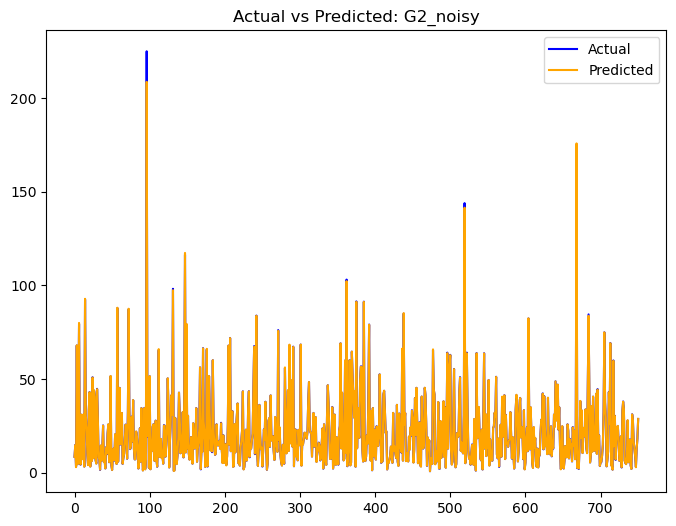

Cross-validated MAE for Group G2: 0.0497


In [137]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def evaluate_model(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy = 100 - mape
    return mae, rmse, r2, mape, accuracy


def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.plot(y_true, label="Actual", color="blue")
    plt.plot(y_pred, label="Predicted", color="orange")
    plt.title(f"Actual vs Predicted: {title}")
    plt.legend()
    plt.show()


voting_model = VotingRegressor(estimators=[
    ('lr', LinearRegression()), 
    ('dt', DecisionTreeRegressor(max_depth=10)), 
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=20))
], weights=[2, 1, 1])


for group, (X, y) in data_groups.items():
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()

    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    
    voting_model.fit(X_train_scaled, y_train)

    
    y_pred_clean = voting_model.predict(X_test_scaled)

    
    mae, rmse, r2, mape, accuracy = evaluate_model(y_test, y_pred_clean)
    print(f"\nMetrics for Group {group} (Clean Data):")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%")

    
    plot_actual_vs_predicted(y_test, y_pred_clean, f'{group}_clean')

    
    noise_factor = 0.1
    X_train_noisy = X_train + noise_factor * np.random.randn(*X_train.shape)
    X_test_noisy = X_test + noise_factor * np.random.randn(*X_test.shape)

    
    X_train_noisy_imputed = imputer.fit_transform(X_train_noisy)
    X_test_noisy_imputed = imputer.transform(X_test_noisy)
    
    X_train_noisy_scaled = scaler.fit_transform(X_train_noisy_imputed)
    X_test_noisy_scaled = scaler.transform(X_test_noisy_imputed)

    
    voting_model.fit(X_train_noisy_scaled, y_train)

    
    y_pred_noisy = voting_model.predict(X_test_noisy_scaled)

    
    mae_noisy, rmse_noisy, r2_noisy, mape_noisy, accuracy_noisy = evaluate_model(y_test, y_pred_noisy)
    print(f"\nMetrics for Group {group} (Noisy Data):")
    print(f"MAE: {mae_noisy:.4f}")
    print(f"RMSE: {rmse_noisy:.4f}")
    print(f"R-squared: {r2_noisy:.4f}")
    print(f"MAPE: {mape_noisy:.2f}%")
    print(f"Accuracy: {accuracy_noisy:.2f}%")

    
    plot_actual_vs_predicted(y_test, y_pred_noisy, f'{group}_noisy')

    
    cv_scores = cross_val_score(voting_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f"Cross-validated MAE for Group {group}: {-cv_scores.mean():.4f}")


In [139]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
